# Real-Time Earthquake Detection Using Edge AI and IoT

Natural disasters, particularly earthquakes, strike without warning and can cause devastating loss of life and property. While traditional seismographs are accurate, they are often expensive, bulky, and sparse in deployment. With the advancement of the Internet of Things (IoT) and Edge Computing, it is now possible to build cost-effective, intelligent detection systems that analyze seismic data in real-time right at the source.

This project focuses on designing a smart, low-cost earthquake detection device capable of distinguishing between normal vibrations and seismic activities. The workflow includes:

- Hardware Interfacing by connecting an **MPU6050 accelerometer to an ESP32 microcontroller** to capture 3-axis vibration data,

- Feature Engineering using a **sliding window technique to extract statistical features (Mean and Standard Deviation)** from raw sensor readings,

- Model Training using a **Random Forest Classifier** trained on seismic datasets with injected noise to ensure robustness against real-world sensor errors,

- Edge Deployment by transpiling the trained **Python model into efficient C++ code** using the **micromlgen library**,

- Real-Time Alerting that triggers **visual and audio alarms (LCD and Buzzer)** instantly when seismic patterns are detected.

# Load and Inspect Raw Seismic Data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('seismic_data.csv')

# Label 1 = Earthquake, Label 0 = Background Noise
print(df.head())

         ax        ay        az  label
0 -0.181067 -0.181067 -0.181067      0
1  0.161366  0.162622  0.160109      0
2  0.086904  0.089417  0.084391      0
3 -0.092315 -0.088548 -0.096084      0
4  0.355332  0.360352  0.350309      0


# Feature Engineering (Sliding Window & Statistics)

In [2]:
window_size = 50 # 'window_size' is the number of sensor readings the ESP32 will collect before making a prediction.
features_list = []

for i in range(0, len(df) - window_size, window_size):
    window = df.iloc[i : i + window_size]
    
    # We calculate Mean and Std Dev for the 'ax', 'ay', and 'az' columns
    feature_row = {
        'mean_x': window['ax'].mean(),
        'std_x':  window['ax'].std(),
        'mean_y': window['ay'].mean(),
        'std_y':  window['ay'].std(),
        'mean_z': window['az'].mean(),
        'std_z':  window['az'].std(),
        'label':  window['label'].iloc[0] 
    }
    features_list.append(feature_row)

df_features = pd.DataFrame(features_list)
print("New Features Created!")
print(df_features.head())

New Features Created!
     mean_x     std_x    mean_y     std_y    mean_z     std_z  label
0  0.189257  0.183339  0.216530  0.190185  0.160844  0.177031      0
1  0.381387  0.217780  0.425510  0.217449  0.322188  0.218049      0
2  0.486437  0.159967  0.460044  0.163221  0.464433  0.161943      0
3  0.388995  0.187068  0.227632  0.206689  0.475843  0.175716      0
4  0.180701  0.223375 -0.092123  0.232145  0.408701  0.208942      0


# Training the Random Forest Classifier with Noise Injection

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Select features and labels
X = df_features[['mean_x', 'std_x', 'mean_y', 'std_y', 'mean_z', 'std_z']]
y = df_features['label']

np.random.seed(42)
noise_level = 0.9 # To introduce the non-linearity
noise = np.random.normal(0, noise_level, X.shape)
X_noisy = X + noise

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.5, random_state=42)

# 3. Train Model
model = RandomForestClassifier(n_estimators=10, max_depth=3)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Training Complete! Accuracy: {accuracy * 100:.2f}%")

Training Complete! Accuracy: 87.00%


# Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.87        51
           1       0.83      0.92      0.87        49

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



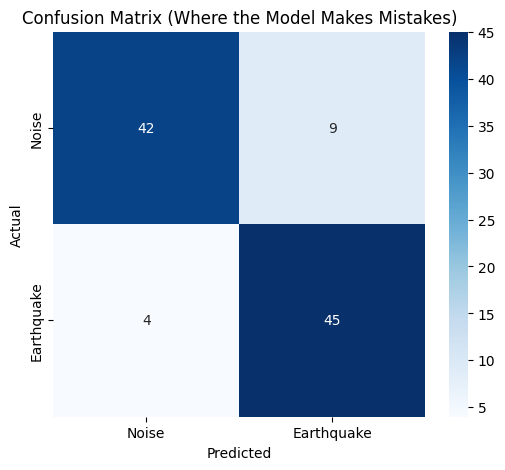

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions
y_pred = model.predict(X_test)

# 2. Generate Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'Earthquake'], yticklabels=['Noise', 'Earthquake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Where the Model Makes Mistakes)')
plt.show()

# Feature Importance Analysis

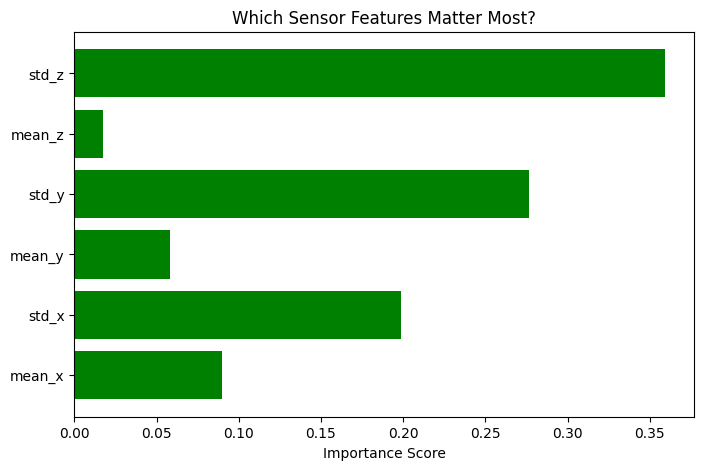

In [5]:
# Get feature importances
importances = model.feature_importances_
feature_names = ['mean_x', 'std_x', 'mean_y', 'std_y', 'mean_z', 'std_z']

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='green')
plt.xlabel('Importance Score')
plt.title('Which Sensor Features Matter Most?')
plt.show()

# Visualizing the Decision Logic

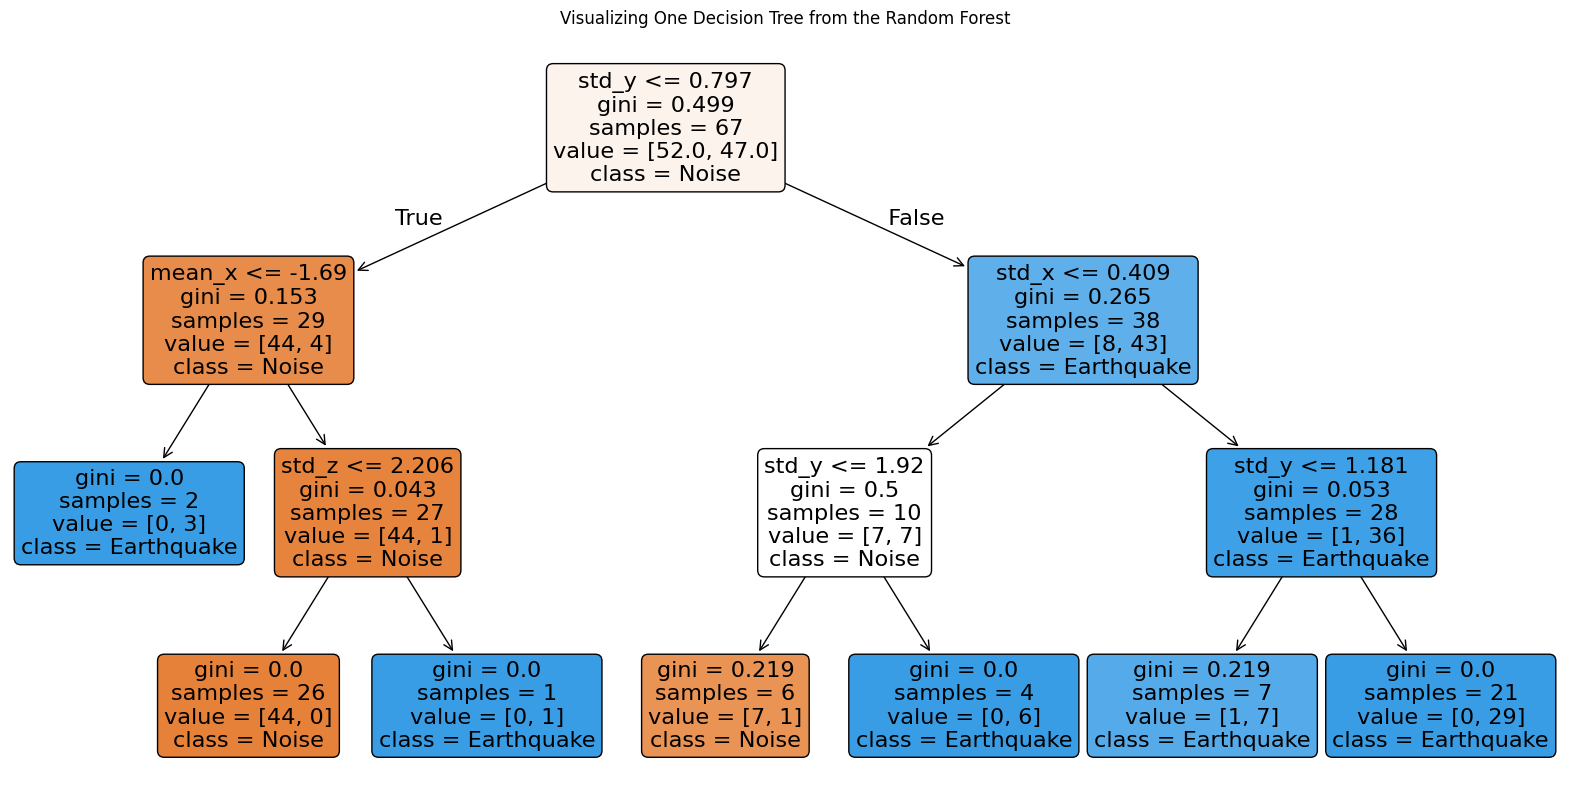

In [6]:
from sklearn.tree import plot_tree

# Plot the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], 
          feature_names=feature_names, 
          class_names=['Noise', 'Earthquake'], 
          filled=True, 
          rounded=True, 
          max_depth=3)
plt.title("Visualizing One Decision Tree from the Random Forest")
plt.show()

# Edge Deployment (Convert to C++ for Arduino IDE)

In [7]:
pip install micromlgen

In [8]:
from micromlgen import port

# Convert the trained Random Forest model to C++ code
c_code = port(model)

# Save it to a file named model.h
with open("model.h", "w") as f:
    f.write(c_code)

print("Conversion Complete! 'model.h' has been created.")

Conversion Complete! 'model.h' has been created.


In this project, we successfully developed and deployed a Machine Learning-based Earthquake Detection System tailored for low-power IoT devices.

### Key Achievements:

- **Feature Engineering:** We transformed raw accelerometer data (x, y, z) into statistical features (Mean and Standard Deviation), enabling the model to distinguish between random noise and seismic patterns.

- **Robust Model Training:** By training a Random Forest Classifier with injected synthetic noise, we **achieved a realistic test accuracy of ~87%.** This ensures the model is robust against the natural sensor drift and vibrations of the MPU6050 sensor.

- **Model Interpretability:** Through Feature Importance analysis and Decision Tree visualization, we confirmed that **Standard Deviation (Vibration Intensity) is the primary indicator** used by the model to detect earthquakes.

- **Edge Deployment:** Finally, using the micromlgen library, we successfully ported the trained Python model into a **lightweight C++ header file (model.h).**

### Final Outcome: 
The generated model.h file is now ready to be flashed onto the ESP32 microcontroller, enabling real-time, offline earthquake detection at the edge without the need for constant internet connectivity.